In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import datetime
from skimage.feature import local_binary_pattern, hog
from skimage import color
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from hog_extractor import extract_hog_features
from lbp_extractor import extract_lbp_features
from cnn_extractor import load_pretrained_model, extract_cnn_features

Importing Dataset


In [34]:
def load_dataset(dataset_path):
    images = []
    labels = []
    # Each subdirectory is a class corresponding to a person
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Only consider JPG images
            for file in os.listdir(person_path):
                if file.lower().endswith(".jpg"):
                    img_path = os.path.join(person_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        # Resize image to a fixed size
                        img = cv2.resize(img, (128, 128))  # Resize to 128x128
                        if len(img.shape) == 2:  # If grayscale, convert to 3 channels
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

                        images.append(img)
                        labels.append(person)
    return images, labels


dataset_path = 'VGG2_Dataset'
images, labels = load_dataset(dataset_path)
print(f"Loaded {len(images)} images for {len(set(labels))} persons.")


Loaded 16936 images for 50 persons.


In [36]:
print("Number of images:",len(images))
print("Number of labels:", len(labels))
print("size of images:", images[0].shape)

Number of images: 16936
Number of labels: 16936
size of images: (128, 128, 3)


Face Detection and Cropping (For Avoiding Background Noise)

In [8]:
import os
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image, cascade_path='haarcascade_frontalface_default.xml'):
    """
    Detects faces in an image using Haar cascades and returns the cropped face region.
    
    Parameters:
    - image: Input image in BGR format.
    - cascade_path: Name of the Haar cascade XML file (default is for frontal face detection).
    
    Returns:
    - face_roi: Cropped face region if a face is detected; otherwise, returns None.
    - faces: List of detected face bounding boxes.
    """
    # Convert image to grayscale for detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    
    # Detect faces (tweak scaleFactor, minNeighbors, minSize as needed)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        return None, faces

    # Option: Choose the largest detected face
    (x, y, w, h) = sorted(faces, key=lambda b: b[2] * b[3], reverse=True)[0]
    face_roi = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (128, 128))
    return face_resized, faces

def load_dataset_with_face_detection(dataset_path):
    """
    Loads images from a dataset folder with one subfolder per person, applies face detection and cropping,
    and returns lists of cropped face images and corresponding labels.
    
    Parameters:
    - dataset_path: Path to the main dataset folder.
    
    Returns:
    - cropped_images: List of cropped face images.
    - labels: List of labels corresponding to each image.
    """
    cropped_images = []
    labels = []
    
    # Iterate over each person's folder
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Process only .jpg files
            for file in os.listdir(person_path):
                if file.lower().endswith('.jpg'):
                    img_path = os.path.join(person_path, file)
                    image = cv2.imread(img_path)
                    if image is None:
                        continue
                    # Apply face detection and crop the face
                    face, _ = detect_and_crop_face(image)
                    if face is not None:
                        cropped_images.append(face)
                        labels.append(person)
                    else:
                        print(f"No face detected in image: {img_path}")
    
    return cropped_images, labels

def display_images(images, labels, num_samples=5):
    """
    Displays a few sample images with their labels in a Jupyter Notebook using Matplotlib.
    
    Parameters:
    - images: List of images in BGR format.
    - labels: Corresponding labels.
    - num_samples: Number of samples to display.
    """
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = images[i]
        label = labels[i]
        # Convert from BGR to RGB for correct color display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_rgb)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Example usage in a Jupyter Notebook:
dataset_path = 'VGG2_Dataset'  # Update with your dataset location
images, labels = load_dataset_with_face_detection(dataset_path)
print(f"Loaded {len(images)} cropped face images for {len(set(labels))} persons.")

# Display a few sample images inline
display_images(images, labels, num_samples=5)


No face detected in image: VGG2_Dataset\n000002\0017_01.jpg
No face detected in image: VGG2_Dataset\n000002\0018_01.jpg
No face detected in image: VGG2_Dataset\n000002\0018_04.jpg
No face detected in image: VGG2_Dataset\n000002\0023_01.jpg
No face detected in image: VGG2_Dataset\n000002\0026_01.jpg
No face detected in image: VGG2_Dataset\n000002\0031_01.jpg
No face detected in image: VGG2_Dataset\n000002\0031_02.jpg
No face detected in image: VGG2_Dataset\n000002\0031_03.jpg
No face detected in image: VGG2_Dataset\n000002\0031_04.jpg
No face detected in image: VGG2_Dataset\n000002\0031_05.jpg
No face detected in image: VGG2_Dataset\n000002\0048_01.jpg
No face detected in image: VGG2_Dataset\n000002\0058_01.jpg
No face detected in image: VGG2_Dataset\n000002\0075_01.jpg
No face detected in image: VGG2_Dataset\n000002\0094_01.jpg
No face detected in image: VGG2_Dataset\n000002\0095_01.jpg
No face detected in image: VGG2_Dataset\n000002\0098_01.jpg
No face detected in image: VGG2_Dataset\

KeyboardInterrupt: 

Example usage of face detection and cropping

Detected 1 face(s) in the image.
Detected face: [[[ 31  28  30]
  [ 31  28  30]
  [ 32  29  31]
  ...
  [197 194 196]
  [197 194 196]
  [198 195 197]]

 [[ 29  26  28]
  [ 29  26  28]
  [ 30  27  29]
  ...
  [198 195 197]
  [200 197 199]
  [203 200 202]]

 [[ 38  35  37]
  [ 36  33  35]
  [ 30  27  29]
  ...
  [196 193 195]
  [202 199 201]
  [206 203 205]]

 ...

 [[ 43  42  51]
  [ 43  42  51]
  [ 40  39  48]
  ...
  [ 79  75  81]
  [ 78  74  80]
  [ 93  89  95]]

 [[ 42  41  50]
  [ 44  43  52]
  [ 42  41  50]
  ...
  [ 84  80  86]
  [ 78  74  80]
  [ 88  84  90]]

 [[ 41  40  50]
  [ 44  43  53]
  [ 43  42  52]
  ...
  [ 85  81  87]
  [ 77  73  79]
  [ 93  89  95]]]
Detected face shape: (151, 151, 3)


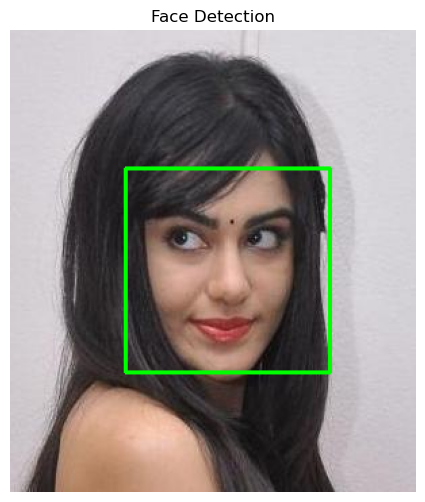

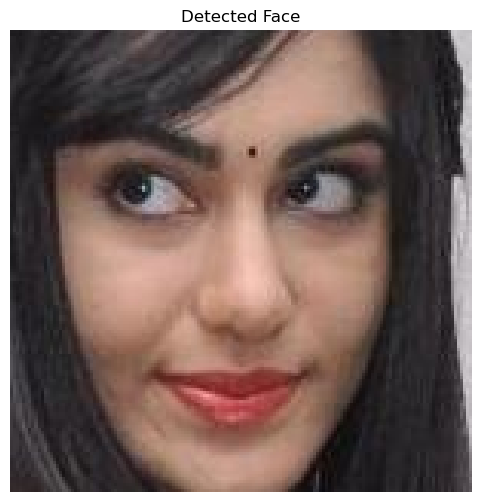

In [37]:
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image, cascade_path='haarcascade_frontalface_default.xml'):
    """
    Detects faces in an image using Haar cascades and returns the cropped face region.
    
    Parameters:
    - image: Input image (BGR format)
    - cascade_path: Filename for the Haar cascade XML file.
    
    Returns:
    - face_roi: Cropped face region if a face is detected; otherwise, returns None.
    - faces: List of detected face bounding boxes.
    """
    # Convert image to grayscale for the face detector
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Load Haar cascade from OpenCV's data directory
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    
    # Detect faces: adjust scaleFactor and minNeighbors as needed
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        print("No faces detected.")
        return None, faces

    # For demonstration, take the first detected face (or choose the largest face)
    (x, y, w, h) = sorted(faces, key=lambda b: b[2] * b[3], reverse=True)[0]
    face_roi = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (128, 128))
    # return face_resized, faces
    return face_roi, faces

def show_image(title, image, cmap=None):
    """
    Displays an image using Matplotlib.
    
    Parameters:
    - title: Title of the plot.
    - image: Image array.
    - cmap: Color map (if needed, e.g., 'gray' for grayscale images).
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage in Jupyter Notebook:
img_path = r"VGG2_Dataset\n000043\0002_01.jpg"  # Update with your image path
image = cv2.imread(img_path)

if image is None:
    print("Image not found or unable to load.")
else:
    face, faces = detect_and_crop_face(image)
    print(f"Detected {len(faces)} face(s) in the image.")
    print(f"Detected face: {face}")
    print(f"Detected face shape: {face.shape if face is not None else None}")
    
    # Convert images from BGR to RGB for proper display in Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if face is not None:
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        # Draw rectangles on the original image for visualization
        for (x, y, w, h) in faces:
            cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Display the original image with detected face boxes
        show_image("Face Detection", image_rgb)
        
        # Display the cropped face
        show_image("Detected Face", face_rgb)
    else:
        print("No face detected in the image.")


Seeing how an image is  resized

Original image shape: (178, 155, 3)
Resized image shape: (200, 200, 3)


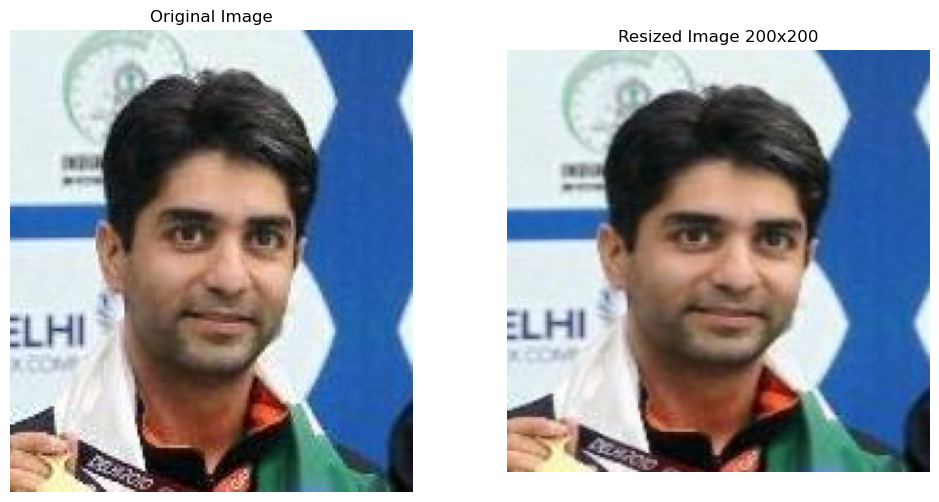

In [38]:
import cv2
import matplotlib.pyplot as plt

# Load the image (update 'path/to/your/image.jpg' with your image path)
image = cv2.imread(r"C:\Users\varchasva\OneDrive\Documents\prmlproject\VGG2_Dataset\n000033\0001_01.jpg")

# Check if image was loaded
if image is None:
    print("Image not found or unable to load.")
else:
    # Print the original image dimensions
    print("Original image shape:", image.shape)

    # Define the target size (width, height)
    target_size = (200, 200)

    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)
    print("Resized image shape:", resized_image.shape)

    # Convert images from BGR (OpenCV default) to RGB for correct display in Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Display the original and resized images side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')

    # Resized image
    plt.subplot(1, 2, 2)
    plt.imshow(resized_rgb)
    plt.title(f"Resized Image {target_size[0]}x{target_size[1]}")
    plt.axis('off')

    plt.show()


In [39]:
print(images[0].shape)
print(images[0])
print(images[1])
print(labels[0])
print(labels[1])

(128, 128, 3)
[[[251 248 244]
  [251 248 244]
  [250 247 243]
  ...
  [253 253 253]
  [253 253 253]
  [253 253 253]]

 [[252 247 244]
  [252 247 244]
  [252 247 244]
  ...
  [253 253 253]
  [253 253 253]
  [253 253 253]]

 [[250 241 238]
  [246 237 234]
  [247 239 236]
  ...
  [253 253 253]
  [253 253 253]
  [253 253 253]]

 ...

 [[ 30  33  59]
  [ 35  37  65]
  [ 27  28  49]
  ...
  [ 95  79  68]
  [ 87  69  62]
  [ 84  65  60]]

 [[ 30  32  56]
  [ 33  32  58]
  [ 24  23  43]
  ...
  [ 91  74  63]
  [ 88  69  62]
  [ 88  68  63]]

 [[ 34  34  55]
  [ 29  26  51]
  [ 33  31  50]
  ...
  [ 97  77  66]
  [ 91  69  63]
  [ 87  65  60]]]
[[[180 209 176]
  [181 210 177]
  [184 211 178]
  ...
  [127 193 164]
  [125 192 161]
  [120 187 156]]

 [[179 209 174]
  [178 208 174]
  [178 208 173]
  ...
  [120 196 168]
  [118 195 164]
  [114 191 159]]

 [[177 209 173]
  [174 207 171]
  [171 205 169]
  ...
  [111 200 170]
  [108 197 166]
  [107 196 163]]

 ...

 [[142 155 159]
  [243 252 255]
  [106

Extracting LBP features of the Images

In [40]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, radius=1, n_points=8):
    """
    Extract LBP features from an image.
    
    Parameters:
    - image: Input image in BGR or grayscale.
    - radius: Radius of circle (in pixels) for LBP.
    - n_points: Number of points to consider around each pixel.
    
    Returns:
    - hist: Normalized histogram of LBP features.
    """
    # If the image has 3 channels, convert it to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Compute the LBP representation of the image using the "uniform" method
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    
    # Calculate the number of bins. For uniform LBP, the number of bins is n_points + 2
    n_bins = int(n_points + 2)
    
    # Build a histogram of the LBP values
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    
    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    return hist

# Example usage:
example_image = cv2.imread('VGG2_Dataset/n000033/0001_01.jpg')
lbp_features = extract_lbp_features(example_image)
print("LBP features:", lbp_features)
print("LBP features shape:", lbp_features.shape)


LBP features: [0.04204422 0.07259877 0.04461762 0.11580283 0.21475172 0.15752084
 0.07303371 0.07825299 0.09797028 0.10340703]
LBP features shape: (10,)


HoG features of the images


In [41]:
from skimage.feature import hog

def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    """
    Extract HoG features from an image.
    
    Parameters:
    - image: Input image in BGR format.
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - orientations: Number of gradient orientations.
    
    Returns:
    - hog_features: A feature vector containing the HoG features.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the HoG features
    hog_features = hog(gray,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
    
    return hog_features

# Example usage:
hog_features = extract_hog_features(example_image)
print("HoG features:", hog_features)
print("HoG features shape:", hog_features.shape)

HoG features: [0.4362703  0.         0.07262603 ... 0.2766157  0.2766157  0.18379562]
HoG features shape: (13608,)


Extracting CNN Features

In [42]:
# Load a pretrained CNN (e.g., ResNet18) and remove the classification head
def load_pretrained_model():
    model = models.resnet18(pretrained=True)  # Load ResNet-18
    model = nn.Sequential(*list(model.children())[:-1])  # Remove classification layer
    model.eval()  # Set model to evaluation mode
    return model

# Define preprocessing pipeline for images
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV image (NumPy array) to PIL
    transforms.Resize((224, 224)),  # Resize to match CNN input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Extract CNN features from an image
def extract_cnn_features(image, model, device='cpu'):
    """
    Extract deep features using a CNN model.

    Parameters:
    - image: Input image in BGR format (OpenCV format).
    - model: Pretrained CNN model.
    - device: 'cuda' or 'cpu' for computation.

    Returns:
    - feature_vector: Extracted features as a NumPy array.
    """
    if image is None:
        return None

    image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
    image = image.to(device)

    with torch.no_grad():  # Disable gradient computation
        features = model(image)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten to 1D vector

    return features.cpu().numpy().flatten()  # Convert to NumPy array

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_pretrained_model().to(device)

# Example: Extract features from one image
example_image = cv2.imread(r'VGG2_Dataset/n000043/0002_01.jpg')  # Update with actual path
cnn_features = extract_cnn_features(example_image, model, device)
print("CNN Feature Vector Shape:", cnn_features.shape)
print("CNN Features:", cnn_features)


CNN Feature Vector Shape: (512,)
CNN Features: [7.20308065e-01 8.38222325e-01 2.24593446e-01 3.52693111e-01
 2.01780815e-02 3.18846315e-01 9.07868799e-03 1.02719104e+00
 7.58447826e-01 8.08548272e-01 9.19561505e-01 5.44380486e-01
 7.39508450e-01 4.25031707e-02 4.18516845e-01 3.44730288e-01
 5.68035133e-02 6.74429759e-02 1.99302420e-01 2.06760788e+00
 1.21083975e+00 1.30837848e-02 2.44138330e-01 1.69638216e-01
 9.07542631e-02 4.56850231e-01 1.25421792e-01 2.84105325e+00
 1.67820171e-01 8.82322714e-02 1.56930506e+00 1.10527784e-01
 4.33903515e-01 6.77723408e-01 9.83089507e-01 0.00000000e+00
 1.21907067e+00 2.41681859e-01 1.66523433e+00 5.46853483e-01
 4.41499949e-01 1.16249263e+00 7.95843378e-02 2.74117757e-02
 1.51625335e+00 8.64853024e-01 5.98563612e-01 1.27991128e+00
 2.20483637e+00 1.52426815e+00 6.36629909e-02 2.81606138e-01
 8.74770224e-01 1.01831041e-01 1.46683395e+00 1.65490165e-01
 1.24082521e-01 2.04414201e+00 9.44952011e-01 2.04234511e-01
 6.10432923e-02 0.00000000e+00 8.96159

Extracting features from all images

In [43]:
def extract_all_features(images):
    """
    images: NumPy array of shape (n_samples, 128, 128, 3)
    Returns: combined features of shape (n_samples, combined_feature_length)
    """
    all_features = []
    for idx, img in enumerate(images):
        # Extract features from each image
        # pixel_feat = img.flatten()
        hog_feat = extract_hog_features(img)
        bnp_feat = extract_lbp_features(img)
        cnn_feat = extract_cnn_features(img, model, device)
        
        # Concatenate all features into one vector
        # combined = np.concatenate([pixel_feat, hog_feat, bnp_feat])

        
        # Without pixel features
        combined = np.concatenate([cnn_feat,hog_feat, bnp_feat])
        all_features.append(combined)
    return np.array(all_features)

In [44]:
all_features=extract_all_features(images)
print("Features shape:", all_features.shape)


Features shape: (16936, 8622)


Creating Dataframe 

In [45]:
import pandas as pd

df = pd.DataFrame(all_features)

# Generate column names for features
df.columns = [f'feature_{i}' for i in range(all_features.shape[1])]

# Add the labels column
df['label'] = labels  # Ensure 'labels' has the same length as features

# Display the shape to confirm
print("DataFrame shape:", df.shape)

# Show first few rows
print(df.head())


DataFrame shape: (16936, 8623)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.351556   2.269215   0.458193   0.036585   0.408684   1.729408   
1   0.518450   1.916363   0.668849   0.095439   0.436880   0.623914   
2   0.247494   0.235780   0.036303   0.196571   0.355528   0.366221   
3   0.124015   1.194227   0.551134   0.631831   0.248300   0.869413   
4   1.187121   0.594572   0.336934   0.102159   0.259407   0.454047   

   feature_6  feature_7  feature_8  feature_9  ...  feature_8613  \
0   0.257782   0.517012   0.889123   1.350800  ...      0.061462   
1   1.912497   0.430057   1.396207   0.882358  ...      0.077209   
2   0.656146   1.317094   0.399848   1.180307  ...      0.081299   
3   0.180963   0.488450   0.957857   0.810449  ...      0.061096   
4   0.897881   0.756032   0.119738   0.685290  ...      0.056274   

   feature_8614  feature_8615  feature_8616  feature_8617  feature_8618  \
0      0.046448      0.096191      0.170227      0.130798 

OneHotEncoding for labels


In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# # Apply One-Hot Encoding
# one_hot_encoder = OneHotEncoder(sparse_output=False) 
# encoded_labels = one_hot_encoder.fit_transform(df[['label']])  # Convert labels to one-hot encoding

# # Convert to DataFrame with proper column names
# label_columns = [f'label_{i}' for i in range(encoded_labels.shape[1])]

# df_encoded = pd.DataFrame(encoded_labels, columns=label_columns)

# # Drop original label column and concatenate encoded labels
# df = df.drop(columns=['label'])
# df = pd.concat([df, df_encoded], axis=1)


In [ ]:
# print(df.head())  # Display first few rows

In [47]:
from sklearn.model_selection import train_test_split

# Features (X) and Labels (y)
# num_classes = len(set(labels))
# X = df.drop(columns=[f"label_{i}" for i in range(num_classes)])  # Feature matrix
# y = df[[f"label_{i}" for i in range(num_classes)]]  # One-hot encoded labels

X=df.drop(columns=['label'])
y=df['label']

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y contains names of persons

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (13548, 8622), Test set size: (3388, 8622)


Applying ML model

Applying Standard Scaling

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)  # X is your feature matrix

Applying PCA to reduce dimensionality

In [75]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # Adjust based on variance plot
X_pca = pca.fit_transform(X_normalized)

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assume X_normalized is your dataset with 8623 features
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance vs. Number of Components")
plt.grid()
plt.show()


KeyboardInterrupt: 

In [71]:
pca = PCA(n_components=0.95)  # Retains 95% of the variance
X_pca = pca.fit_transform(X_normalized)

print("Number of selected components:", pca.n_components_)


KeyboardInterrupt: 

Train-Test Split

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (13548, 100), Test set size: (3388, 100)


Random Forest Classifier

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=50,  # Reduce trees for faster training
    max_depth=15,     # Limit depth to prevent overfitting
    min_samples_split=5,  # Require more samples per split (reduces overfitting)
    n_jobs=-1,  # Use all CPU cores for parallel processing
    random_state=42
)

rf_model.fit(X_train, y_train)
print(f"Random Forest Accuracy: {rf_model.score(X_test, y_test):.4f}")

Random Forest Accuracy: 0.3202


KNN-Classifier

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Try different k values
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred))


AttributeError: 'NoneType' object has no attribute 'split'

Support Vector Machine

In [79]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1.0, gamma='scale')  # RBF kernel is often best for faces
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))


SVM Accuracy: 0.5882526564344747


XGBoost 

In [80]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))


ModuleNotFoundError: No module named 'xgboost'

Logistic Regression

In [81]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))


Logistic Regression Accuracy: 0.4988193624557261


c:\Users\varchasva\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble Learning